# Chap04 - 합성곱 신경망 CNN

**합성곱 신경망(CNN, Convolutional Neural Network)**와 관련된 구성 요소 및 메소드에 대해 알아보고, MNIST 데이터 분류 및 CIFAR-10 데이터에 대해 알아보도록 하자.

## 4.1 CNN 소개

 > 여기서는 CNN에 대해 간략하게 소개한다. 자세히 알고 싶다면 [합성곱신경망](http://excelsior-cjh.tistory.com/79?category=940400)을 참고하면 된다. 

먼저, **합성곱(convolution)**신경망과 **완전연결(fully connected)**신경망의 근본적인 차이점은 계층간의 연결이다.

![](./images/cnn-vs-fcn.png)


완전연결 신경망은 이름에서도 알 수 있듯이 각 유닛(뉴런)이 앞 계층의 모든 유닛과 연결되어 있다. 반면, 합성곱 계층에서는 각각의 유닛은 이전 계층에서 근접해 있는 몇 개의 유닛들에만 연결된다. 또한 모든 유닛은 이전 계층에 동일한 방법으로 연결되어 있으므로 같은 값의 가중치와 구조를 공유한다. 그리고 이 연결 사이에 **합성곱** 연산이 들어 있어 이 신경망을 합성곱 신경망이라 부른다.

<img src="./images/cnn-vs-fcn2.png" width="50%" height="50%">

CNN이 등장한 배경으로는 여러가지 설명이 있는데, 첫 번째는 신경과학적 영감이다. 두 번째는 이미지의 본질에 대한 통찰과 관련이 있고, 세 번째는 학습 이론과 관련이 있다.

보통 합성곱 신경망을 설명할 때 생물학에서 영감을 받은 모델로 설명을 많이 한다. 합성곱 신경망에 대한 블로그 포스팅이나 설명에서 아래의 그림(출처:[distillery.com](https://distillery.com/blog/implementing-human-brain-exploring-potential-convolutional-neural-networks/))과 같은 고양이 그림을 본적이 있을 것이다.

<img src="./images/cnn-motif.png" width="50%" height="50%">

위의 그림은 고양이가 어떤 물체를 인식할 때, 모든 뉴런이 반응하는 것이 아니라 물체의 모양이나 패턴에 따라 특정한 뉴런이 반응한다는 것에 영감을 받아 CNN이 등장하게 되었다는 설명이다. 

두 번째인 공학 관점에서의 설명은, 이미지의 본질에 대해 관한 것이다. 예를 들어서, 이미지 속에서 고양이 얼굴을 찾는다고 하면 이미지 내의 어느 위치에 있는지와 무관하게 찾을 수 있어야 한다. 이것은 동일한 물체가 이미지의 다른 위치에서 발견될 수 있다는 이미지의 속성을 반영한 것이다. 이러한 것을 **불변성(invariance)**이라고 하며, 이러한 불변성은 회전이 발생하거나 조명 조건이 변하더라도 유지되어야 한다. (아래 그림 출처: www.cc.gatech.edu)

<img src="./images/trans_invar.png" width="50%" height="50%">

따라서 객체 인식 시스템을 만들 떄는 변환에 대한 불변성이 있어야 한다. 이러한 관점에서 합성곱 신경망은 전체의 공간 영역에서 이미지의 동일한 특징을 계산한다.

마지막으로, 합성곱 구조는 하나의 정규화(regularization) 과정이라고 볼 수 있다. 정규화(Regularization)은 머신러닝이나 통계학에서 주로 정답의 복잡도에 패널티를 가해 최적화 문제에 제한을 두는 것을 말하며, 이주어진 데이터에 오버피팅(overfitting)을 방지하기위해 사용된다. 합성곱(convolution) 계층은 정해진 크기의 합성곱 보통 매우 작은 합성곱의 크기로 자유도(degree of freedom)를 줄인다.

## 4.2 MNIST 분류기: 버전 2

2장 [2.4 소프트맥스 회귀](http://excelsior-cjh.tistory.com/149)를 이용한 MNIST 분류를 이번에는 CNN으로 MNIST 분류기를 구현해보도록 하자.

### 4.2.1 합성곱(Convolution)
 
합성곱 연산은 합성곱 신경망에서 계층이 연결되는 가장 기본적인 방법이다. 텐서플로에서 기본으로 제공되는 [`conv2d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)함수를 사용할 수 있다.

```python
tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
```

`x`는 입력 이미지 또는 이전 합성곱 계층에서 출력된 특징맵(Feature Map) 데이터이다. CNN 모델에서는 합성곱 계층(convolution layer)을 층층이 쌓는데 **특징맵(Feature Map)**은 합성곱 계층의 출력을 말한다. 즉, 필터(커널) 및 다른 연산들을 적용한 **'처리된 이미지'**로 생각하면 된다. 필터(또는 커널)은 $m \times n$ 행렬로 구성된 가중치(`W`) 이다. 이러한 필터를 가지고 아래으 그림 처럼 스트라이딩(striding)하며 합성곱 연산을 수행한다. 

![](./images/conv-layer.gif)

합성곱 연산의 결과는 `x`와 `W`의 형태에 따라 달라지며, MNIST 분류기에서는 4차원 값이다. MNIST 이미지 데이터 `x`의 `shape`은 `[None, 28, 28, 1]` 이다. `x`의 `shape`에 대한 설명은 다음과 같다.

- `x = [None, 28, 28, 1]`
    - *None* : 입력될 이미지의 개수는 정해지지 않았으므로 `None`이며, batch-size가 입력된다.
    - *28, 28* : MNIST 데이터는 `28 x 28` 픽셀이다.
    - *1* : 1은 색 채널(channel)을 의미하며, MNIST 데이터는 회색조(grayscale)이미지 이므로 한 개의 채널을 가진다.
    

예제에서 사용될 `W`의 형태는 다음과 같다.

- `W = [5, 5, 1, 32]`
    - *(5, 5, 1)* : 합성곱에 사용될 '윈도우(window)'의 크기를 나타내며, shape는 `5 x 5`이며, `1`은 입력 채널을 의미한다(처음 이미지가 입력될 때는 회색조 이미지이므로 채널이 1이지만, 나중에 합성곱 계층에서 출력된 특징맵의 수를 의미).
    - *32* : 출력될 특징맵의 수(out-channels)다. 합성곱 계층의 아이디어가 이미지 전체에 동일한 특징을 계산하는 것이며, 동일한 특징을 여러번 계산하기 위해 여러개의 필터를 사용하는 것이다.

`strides` 인자는 이미지(또는 특징맵) `x` 위에서 필터 `W`의 이동할 간격을 조절한다. 위의 `strides=[1, 1, 1, 1]`은 필터가 1칸 씩 이동하는 '완전한' 합성곱이다. 스트라이드(Stride)는 보통 1과 같이 작은 값이 더 잘 작동하며, Stride가 1일 경우 입력 데이터의 spatial 크기는 pooling 계층에서만 조절하게 할 수 있다. 

마지막으로 `padding`인자는 `SAME`으로 설정했는데, 패딩(padding)은 합성곱 연산을 수행하기 전, 입력데이터 주변을 특정값으로 채워 늘리는 것을 말한다. `SAME`으로 설정하면 합성곱 계층의 출력결과가 입력 이미지인 `x`의 크기와 같도록 해준다.

#### 활성화 함수

합성곱 계층이나 완전 연결계층에 상관없이 선형 계층에 비선형 함수인 **활성화 함수(activation function)**을 적용하는 것이 일반적이다. 그 이유는 합성곱 연산이나 완전 연결계층의 연산은 선형연산이므로 중간에 비선형 활성화 함수를 사용하지 않으면 신경망 계층이 깊어진다고 해도 아무런 효율이 없기 때문이다.

![](./images/activation.png)

### 4.2.2 풀링(Pooling)

합성곱 계층 다음에는 풀링을 하는 것이 일반적이다. **풀링(pooling)**은 각 특징맵 내에서 집계 함수(평균/최대값)를 사용해 데이터의 크기를 줄이는 것을 의미한다. 

![](./images/pooling.png)

풀링의 배경에는 기술적인 이유와 이론적인 이유가 있다. 기술적 측면에서 풀링은 차례로 처리되는 데이터의 크기를 줄인다. 이 과정으로 모델의 전체 매개변수의 수를 크게 줄일 수 있다. 

풀링의 이론적 측면은 계산된 특징이 이미지 내의 위치에 대한 변화에 영항을 덜 받기 때문이다. 예를 들어 이미지의 우측 상단에서 눈을 찾는 특징은, 눈이 이미지의 중앙에 위치하더라도 크게 영향을 받지 않아야 한다. 그렇기 때문에 풀링을 이용하여 불변성을 찾아내서 공간적 변화를 극복할 수 있다.

<img src="./images/pooling02.png" width="60%" height="60%">

이번 예제에서는 각 특징 맵에 `2 x 2` Max-pooling 연산을 적용한다.

```python
tf.nn.maxpool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
```

`ksize`인자는 풀링의 크기를 정의하고, `strides`인자는 풀링의 이동간격을 의미한다. 이러한 풀링의 결과는 높이(height)와 너비(width)는 절반이 되고 크기는 $\frac{1}{4}$이 된다.

### 4.2.3 드롭아웃

모델에 필요한 마지막 요소는 **드롭아웃(dropout)**이다. 드롭아웃은 정규화(regularization)를 위한 트릭이며 임의의 뉴런을 무작위로 선택에 선택된 뉴런들을 제외하고 학습시키는 방법이다. 

<img src="./images/dropout.png" width="50%" height="50%">

위의 그림처럼 학습 중 값을 `0`으로 세팅해 선택된 뉴런들을 '꺼버리는'방식으로 드롭아웃시킨다. 테스트 단계에서는 드롭아웃 없이 전체 신경망을 그대로 사용한다. 텐서플로에서는 다음과 같이 드롭아웃을 구현할 수 있다.

```python
tf.nn.dropout(layer, keep_prob=0.5)
```

`keep_prob`인자는 각 단계에서 학습을 유지할 뉴런(드롭아웃 시키지 않는)의 비율이다. 나중에 테스트 단계에서는 `keep_prob=1`로 설정한다. 

### 4.2.4 모델

이제 앞에서 알아본 내용을 토대로 CNN모델을 구현해보자. 

먼저, 계층을 만드는데 사용할 헬퍼함수를 정의한다. 이 헬퍼함수를 이용해 짧고 가독성 좋은 코드를 작성할 수 있다. 헬퍼함수는 다음과 같다(`layers.py`)

| 헬퍼함수            | 설명                                                         |
| ------------------- | ------------------------------------------------------------ |
| `weight_variable()` | 합성곱 계층 및 완전 연결 계층의 가중치를 지정한다. 표준편차가 0.1인 절단정규분포를 사용하여 랜덤하게 초기화한다. |
| `bias_variable()`   | 합성곱 계층 및 완전 연결 계층의 편향값을 정의한다. 모두 0.1 상수로 초기화한다. |
| `conv2d()`          | 합성곱 연산을 정의한다. `stride` 를 1로 설정하여 완전한 합성곱을 수행한다. 또한 `padding=SAME` 을 통해 입력과 같은 크기를 출력한다. |
| `max_pool_2x2()`    | 맥스 풀링을 통해 특징 맵의 크기를 $\frac{1}{4}$ 로 줄인다.   |
| `conv_layer()`      | 합성곱 계층으로 `conv2d()` 함수에 정의된 선형 합성곱에 편향값을 더한 후 비선형 함수인 ReLU를 적용한다. |
| `full_layer()`      | 편향을 적용한 완전 연결 계층이다.                            |



In [1]:
# layers.py

import tensorflow as tf

def weight_variables(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

# convolution layer
def conv_layer(input_, shape):
    W = weight_variables(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input_, W) + b)

# fully-connected layer
def full_layer(input_, size):
    in_size = int(input_.get_shape()[1])
    W = weight_variables([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input_, W) + b

위의 헬퍼함수를 이용해서 아래의 그림과 같이 CNN모델을 구성해보자.

<img src="./images/cnn-model.png" width="80%" height="80%">

In [8]:
# mnist_cnn.py
import numpy as np
import tensorflow as tf

from layers import conv_layer, max_pool_2x2, full_layer

# Hyper Parameters
STEPS = 5000
MINIBATCH_SIZE = 50

# mnist 불러오기
def mnist_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

    # Train - Image
    train_x = train_x.astype('float32') / 255
    # Train - Label(OneHot)
    train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)

    # Test - Image
    test_x = test_x.astype('float32') / 255
    # Test - Label(OneHot)
    test_y = tf.keras.utils.to_categorical(test_y, num_classes=10)
    
    return (train_x, train_y), (test_x, test_y)


(train_x, train_y), (test_x, test_y) = mnist_load()

dataset = tf.data.Dataset.from_tensor_slices(({"image": train_x}, train_y))
dataset = dataset.shuffle(100000).repeat().batch(MINIBATCH_SIZE)
iterator = dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

# 왜 느릴까?
# def next_batch(features, labels, batch_size):
#     # An input function for training
        
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices(({"image": features}, labels))
#     # Shuffle, repeat, and batch the examples.
#     dataset = dataset.shuffle(buffer_size=1000).repeat().batch(batch_size)
    
#     # Return the read end of the pipeline.
#     return dataset.make_one_shot_iterator().get_next()

In [9]:
# CNN 모델링
x = tf.placeholder(tf.float32, shape=[None, 28, 28])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x_image, shape=[5, 5, 1, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full_1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full_1_drop, 10)


# 손실함수
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_conv, labels=y_))
# 최적화함수
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 정확도 계산
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 학습
    for step in range(STEPS):
        batch_xs, batch_ys = sess.run(next_batch)
        _, cost_val = sess.run([train_step, cross_entropy], feed_dict={x: batch_xs['image'], 
                                                                       y_: batch_ys, 
                                                                       keep_prob: 0.5})
        
        if (step+1) % 500 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs['image'],
                                                           y_: batch_ys, 
                                                           keep_prob: 1})
            print("Step : {}, cost : {}, training accuracy: {}".format(step+1, cost_val, 
                                                                       train_accuracy))
            
    X = test_x.reshape([10, 1000, 28, 28])
    Y = test_y.reshape([10, 1000, 10])

    test_accuracy = np.mean(
            [sess.run(accuracy, feed_dict={x: X[i], 
                                           y_: Y[i], 
                                           keep_prob: 1.0}) for i in range(10)])

print("test accuracy: {}".format(test_accuracy))

Step : 500, cost : 0.17628227174282074, training accuracy: 0.9599999785423279
Step : 1000, cost : 0.14772018790245056, training accuracy: 1.0
Step : 1500, cost : 0.07791811227798462, training accuracy: 1.0
Step : 2000, cost : 0.025532126426696777, training accuracy: 0.9800000190734863
Step : 2500, cost : 0.1329123079776764, training accuracy: 0.9599999785423279
Step : 3000, cost : 0.08091112971305847, training accuracy: 1.0
Step : 3500, cost : 0.08739538490772247, training accuracy: 0.9800000190734863
Step : 4000, cost : 0.1634717434644699, training accuracy: 0.9800000190734863
Step : 4500, cost : 0.014107899740338326, training accuracy: 1.0
Step : 5000, cost : 0.12679265439510345, training accuracy: 0.9800000190734863
test accuracy: 0.9877001047134399


위의 코드에서는 `train_accuracy`와 `test_accuracy`를 살펴보면 다음과 같다.

- `train_accuracy`: 매 500회의 학습이 진행될 때마다 모델의 정확도를 출력한다. 학습 단계 중간 시점에서 학습 데이터에 대한 모델의 성능을 추정할 수 있다.
- `test_accuracy`: 테스트 과정을 1,000개의 이미지로 구성된 10개의 블록으로 나누었다. 대량의 데이터를 테스트 할 경우 중요한 작업이다.

## 4.3 CIFAR10

**CIFAR10**은 컴퓨터 비전과 머신러닝에서 오랜 역사를 가지고 있는 데이터이다. MNIST와 같이 딥러닝 모델을 테스트하여 비교하는 데 많이 사용되고 있다. 

> CIFAR10 데이터셋(http://www.cs.toronto.edu/~kriz/cifar.html)은 $32 \times 32$ 화소 크기의 6만개의 컬러 이미지 셋으로 각 이미지는 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭의 10개 분류 중 하나에 속한다.  

### 4.3.1 CIFAR10 데이터 읽어 들이기

CIFAR10 데이터를 다운로드 받고 읽어오기 위해서, 4.2에서 MNIST 데이터를 불러올때와 비슷하게 `tf.kears.datasets.cifar10.load_data()`를 사용한다. 이 메소드는 학습데이터와 테스트 데이터를 다음과 같이 반환한다.

```python
(train_x, train_y), (test_x, test_y) = tf.kears.datasets.cifar10.load_data()
```

거기에 추가적으로 `cifar10_load()` 함수를 만들고 정규화(normalization) 및 one-hot 인코딩을 적용해 주었다.

In [36]:
def cifar10_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

    # Train - Image
    train_x = train_x.astype('float32') / 255
    # Train - Label(OneHot)
    train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)

    # Test - Image
    test_x = test_x.astype('float32') / 255
    # Test - Label(OneHot)
    test_y = tf.keras.utils.to_categorical(test_y, num_classes=10)
    
    return (train_x, train_y), (test_x, test_y)


(train_x, train_y), (test_x, test_y) = cifar10_load()

dataset = tf.data.Dataset.from_tensor_slices(({"image": train_x}, train_y))
dataset = dataset.shuffle(100000).repeat().batch(MINIBATCH_SIZE)
iterator = dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

CIFAR10의 학습/테스트 데이터의 크기는 다음과 같다. CIFAR10에는 5만개의 학습 이미지와 1만개의 테스트 이미지가 있다.

In [40]:
print("Number of train images: {}".format(len(train_x)))
print("Number of train labels: {}".format(len(train_y)))
print("Number of test images: {}".format(len(test_x)))
print("Number of test labels: {}".format(len(test_y)))

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test labels: 10000


불러온 CIFAR10 데이터 셋을 `matplotlib`을 이용해 출력해보자. `display_cifar()`는 CIFAR10 이미지를 랜덤하게 100개 추출하여 출력해주는 함수이다.

In [37]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

matplotlib.rc('font', family='NanumGothic')  # Linumx
# matplotlib.rc('font', family='AppleGothic')  # Mac

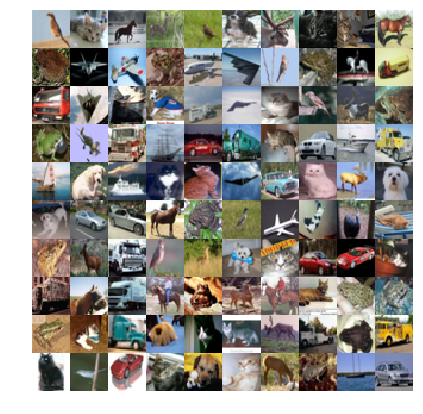

In [38]:
def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
                    for i in range(size)])
    plt.imshow(im)
    plt.show()
    
figsize(15, 7)
display_cifar(train_x, 10)

### 4.3.2 간단한 CIFAR10 모델

4.2에서 구현한 CNN 모델을 CIFAR10 데이터에 적용해 보자.

In [41]:
(train_x, train_y), (test_x, test_y) = cifar10_load()

dataset = tf.data.Dataset.from_tensor_slices(({"image": train_x}, train_y))
dataset = dataset.shuffle(100000).repeat().batch(MINIBATCH_SIZE)
iterator = dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

In [56]:
# Hyper Parameters
BATCH_SIZE = 50
STEPS = 10000

# CNN 모델링
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 8*8*64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full_1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full_1_drop, 10)


# 손실함수
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_conv, labels=y_))
# 최적화함수
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

# 정확도 계산
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [57]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 학습
    for step in range(STEPS):
        batch_xs, batch_ys = sess.run(next_batch)
        _, cost_val = sess.run([train_step, cross_entropy], feed_dict={x: batch_xs['image'], 
                                                                       y_: batch_ys, 
                                                                       keep_prob: 0.5})
        
        if (step+1) % 1000 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs['image'],
                                                           y_: batch_ys, 
                                                           keep_prob: 1})
            print("Step : {}, cost : {}, training accuracy: {}".format(step+1, cost_val, 
                                                                       train_accuracy))
            
    X = test_x.reshape([10, 1000, 32, 32, 3])
    Y = test_y.reshape([10, 1000, 10])

    test_accuracy = np.mean(
            [sess.run(accuracy, feed_dict={x: X[i], 
                                           y_: Y[i], 
                                           keep_prob: 1.0}) for i in range(10)])

print("test accuracy: {}".format(test_accuracy))

Step : 1000, cost : 1.1010699272155762, training accuracy: 0.6800000071525574
Step : 2000, cost : 0.8581387996673584, training accuracy: 0.800000011920929
Step : 3000, cost : 1.080075740814209, training accuracy: 0.7200000286102295
Step : 4000, cost : 1.284070611000061, training accuracy: 0.7599999904632568
Step : 5000, cost : 0.5776426196098328, training accuracy: 0.9200000166893005
Step : 6000, cost : 0.5375992059707642, training accuracy: 0.8799999952316284
Step : 7000, cost : 0.4935189187526703, training accuracy: 0.9200000166893005
Step : 8000, cost : 0.6959868669509888, training accuracy: 0.8799999952316284
Step : 9000, cost : 0.3572390377521515, training accuracy: 0.9399999976158142
Step : 10000, cost : 0.236542209982872, training accuracy: 0.9599999785423279
test accuracy: 0.7075999975204468


위의 모델은 정확도가 약 70%의 정확도를 달성한다. 

이번에는 위의 모델에 128개의 특징 맵과 드롭아웃을 가진 세 번째 합성곱 계층(conv3)을 추가해보자.

In [58]:
%%time

# CNN 모델링
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

# 세 번째 합성곱 계층 추가
conv3 = conv_layer(conv2_pool, shape=[5, 5, 64, 128])
conv3_pool = max_pool_2x2(conv3)

conv3_flat = tf.reshape(conv3_pool, [-1, 4*4*128])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full_1 = tf.nn.relu(full_layer(conv3_drop, 512))
full_1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full_1_drop, 10)


# 손실함수
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_conv, labels=y_))
# 최적화함수
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

# 정확도 계산
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 학습
    for step in range(STEPS):
        batch_xs, batch_ys = sess.run(next_batch)
        _, cost_val = sess.run([train_step, cross_entropy], feed_dict={x: batch_xs['image'], 
                                                                       y_: batch_ys, 
                                                                       keep_prob: 0.5})
        
        if (step+1) % 1000 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs['image'],
                                                           y_: batch_ys, 
                                                           keep_prob: 1})
            print("Step : {}, cost : {}, training accuracy: {}".format(step+1, cost_val, 
                                                                       train_accuracy))
            
    X = test_x.reshape([10, 1000, 32, 32, 3])
    Y = test_y.reshape([10, 1000, 10])

    test_accuracy = np.mean(
            [sess.run(accuracy, feed_dict={x: X[i], 
                                           y_: Y[i], 
                                           keep_prob: 1.0}) for i in range(10)])

print("test accuracy: {}".format(test_accuracy))

Step : 1000, cost : 1.5227357149124146, training accuracy: 0.47999998927116394
Step : 2000, cost : 1.2849160432815552, training accuracy: 0.6000000238418579
Step : 3000, cost : 1.516249656677246, training accuracy: 0.5199999809265137
Step : 4000, cost : 1.1688849925994873, training accuracy: 0.6399999856948853
Step : 5000, cost : 0.8774319291114807, training accuracy: 0.7400000095367432
Step : 6000, cost : 1.0131981372833252, training accuracy: 0.7599999904632568
Step : 7000, cost : 0.8392598032951355, training accuracy: 0.8199999928474426
Step : 8000, cost : 0.8835957050323486, training accuracy: 0.6800000071525574
Step : 9000, cost : 0.9495877027511597, training accuracy: 0.7400000095367432
Step : 10000, cost : 1.0405669212341309, training accuracy: 0.7599999904632568
test accuracy: 0.7201999425888062
CPU times: user 55.3 s, sys: 8.26 s, total: 1min 3s
Wall time: 45.2 s


#### CIFAR10 유명 모델 축소판

다음은 CIFAR10 분류에 잘맞는 모델을 축소판인 코드를 보도록 하자.

상수 `C1, C2, C3`은 각각 합성곱 블록 각 계층의 특징 맵의 수를 나타내며, `F1`은 완전 연결 계층의 유닛의 수를 나타낸다. 

In [63]:
# 각 계층의 출력 채널 개수
C1, C2, C3 = 30, 50, 80 
F1 = 500

conv1_1 = conv_layer(x, shape=[3, 3, 3, C1])
conv1_2 = conv_layer(conv1_1, shape=[3, 3, C1, C1])
conv1_3 = conv_layer(conv1_2, shape=[3, 3, C1, C1])
conv1_pool = max_pool_2x2(conv1_3)
conv1_drop = tf.nn.dropout(conv1_pool, keep_prob=keep_prob)

conv2_1 = conv_layer(conv1_drop, shape=[3, 3, C1, C2])
conv2_2 = conv_layer(conv2_1, shape=[3, 3, C2, C2])
conv2_3 = conv_layer(conv2_2, shape=[3, 3, C2, C2])
conv2_pool = max_pool_2x2(conv2_3)
conv2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob)

conv3_1 = conv_layer(conv2_drop, shape=[3, 3, C2, C3])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, C3, C3])
conv3_3 = conv_layer(conv3_2, shape=[3, 3, C3, C3])
conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1],
                            padding="SAME")
conv3_flat = tf.reshape(conv3_pool, [-1, C3])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full1 = tf.nn.relu(full_layer(conv3_drop, F1))
full1_drop = tf.nn.dropout(full1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

In [64]:
%%time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 학습
    for step in range(STEPS):
        batch_xs, batch_ys = sess.run(next_batch)
        _, cost_val = sess.run([train_step, cross_entropy], feed_dict={x: batch_xs['image'], 
                                                                       y_: batch_ys, 
                                                                       keep_prob: 0.5})
        
        if (step+1) % 1000 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs['image'],
                                                           y_: batch_ys, 
                                                           keep_prob: 1})
            print("Step : {}, cost : {}, training accuracy: {}".format(step+1, cost_val, 
                                                                       train_accuracy))
            
    X = test_x.reshape([10, 1000, 32, 32, 3])
    Y = test_y.reshape([10, 1000, 10])

    test_accuracy = np.mean(
            [sess.run(accuracy, feed_dict={x: X[i], 
                                           y_: Y[i], 
                                           keep_prob: 1.0}) for i in range(10)])

print("test accuracy: {}".format(test_accuracy))

Step : 1000, cost : 1.2386534214019775, training accuracy: 0.6399999856948853
Step : 2000, cost : 1.2786847352981567, training accuracy: 0.6200000047683716
Step : 3000, cost : 1.022018313407898, training accuracy: 0.6600000262260437
Step : 4000, cost : 1.2519090175628662, training accuracy: 0.6800000071525574
Step : 5000, cost : 1.0143786668777466, training accuracy: 0.699999988079071
Step : 6000, cost : 1.1999915838241577, training accuracy: 0.6600000262260437
Step : 7000, cost : 0.8722643852233887, training accuracy: 0.7599999904632568
Step : 8000, cost : 0.9225350022315979, training accuracy: 0.7200000286102295
Step : 9000, cost : 0.8183228969573975, training accuracy: 0.8399999737739563
Step : 10000, cost : 1.0131831169128418, training accuracy: 0.7400000095367432
test accuracy: 0.7129999399185181
CPU times: user 55.8 s, sys: 8.52 s, total: 1min 4s
Wall time: 45.2 s
